In [1]:
import os 
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches 
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Layer 

from models.face_recognition.model_small import create_model 
from models.face_recognition.align import AlignDlib 
from triplet_loss import TripletLossLayer 
from lfw_preprocessor import LfwDataGenerator 

In [2]:
# Input for anchor, positive and negative images 
in_a = Input(shape=(96, 96, 3), name = "img_a")
in_p = Input(shape=(96, 96, 3), name = "img_p")
in_n = Input(shape=(96, 96, 3), name = "img_n")

# creating the base model from model_small
model_sm = create_model()

# Output embedding vectors from anchor, positive and negative images 
# The model weights are shared (Triplet network)
emb_a = model_sm(in_a)
emb_p = model_sm(in_p)
emb_n = model_sm(in_n)

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors 
triplet_loss_layer = TripletLossLayer(alpha = 0.2, name = 'triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images 
model = Model([in_a, in_p, in_n], triplet_loss_layer)

model.load_weights('ckpts/hh2_epoch057_loss0.146.hdf5')
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_a (InputLayer)              [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
img_p (InputLayer)              [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
img_n (InputLayer)              [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 128)          2047216     img_a[0][0]                      
                                                                 img_p[0][0]           

In [3]:
base_model = model.layers[3]
base_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________

In [4]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path, upper_limit):
    metadata = []
    count = 0
    for i in sorted(os.listdir(path)):
        if count == upper_limit: 
            break
            
        for f in sorted(os.listdir(os.path.join(path, i))):
            if count == upper_limit: 
                break
                
            count += 1
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]
    
def align_image(img):
        alignment = AlignDlib('models/landmarks.dat')
        bb = alignment.getLargestFaceBoundingBox(img)
        if bb is None:
            return cv2.resize(img, (96,96))
        else:
            return alignment.align(96, 
                                   img, 
                                   bb,
                                   landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)


In [5]:
metadata = load_metadata('data/lfw', 100)
# Initialize the OpenFace face alignment utility 
alignment = AlignDlib('models/landmarks.dat')

In [6]:
embeddings = np.empty((metadata.shape[0], 128))
# use model to predicct the embeddings from the dataset 
for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    img = img.astype('float32')
    img = img / 255.0
    img = np.expand_dims(img, axis = 0)
    embeddings[i] = base_model.predict(img)
    
    # for displaying the progress of creating embeddings 
    if i%1 == 0: print(i, end = " ")
    if i == len(metadata) - 1:print('done')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 done


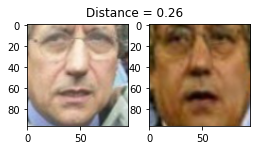

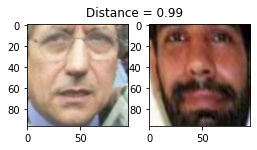

In [24]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))
def show_pair(embeddings, id1, id2):
    plt.figure(figsize = (4, 2))
    plt.suptitle(f'Distance = {distance(embeddings[id1], embeddings[id2]):.2f}')
    plt.subplot(1, 2, 1)
    plt.imshow(align_image(load_image(metadata[id1].image_path())))
    plt.subplot(1, 2, 2)
    plt.imshow(align_image(load_image(metadata[id2].image_path())))
    
 # showing positive pair 
show_pair(embeddings, 85, 86)
    # negative pair 
show_pair(embeddings, 85, 24)   

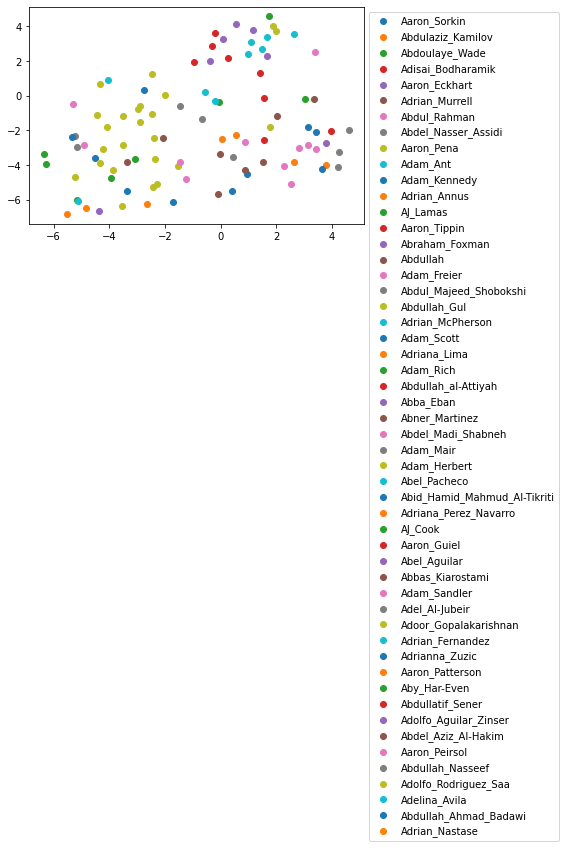

In [12]:
from sklearn.manifold import TSNE 

# create 2d cluster estimates for visualization 
X_embedded = TSNE(n_components = 2).fit_transform(embeddings)
targets = np.array([m.name for m in metadata])
for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label = t)
plt.legend(bbox_to_anchor = (1, 1)); 